# GOOGLE COLAB PART

In [ ]:
!sudo apt-get install python3.9

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1

In [ ]:
!sudo update-alternatives --config python3

In [19]:
!python --version

Python 3.9.22


In [22]:
%cd /content/drive/MyDrive/Projets_perso/Projet_IA/Radiography_project_LungIsolation

/content/drive/MyDrive/Projets_perso/Projet_IA/Radiography_project_LungIsolation


In [24]:
!git clone https://github.com/AntoinBs/Radiography_project_LungIsolation.git

Cloning into 'Radiography_project_LungIsolation'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 44 (delta 13), reused 38 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 14.88 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [25]:
%cd Radiography_project_LungIsolation

/content/drive/MyDrive/Projets_perso/Projet_IA/Radiography_project_LungIsolation/Radiography_project_LungIsolation


# MODELISATION PART

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split

2025-05-14 22:33:47.475602: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 22:33:47.624190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747254827.678262  319049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747254827.695479  319049 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747254827.819677  319049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Chargement des données

In [3]:
# Chargement des métadonnées
metadata = pd.read_csv(r'../data/processed/metadata.csv')
metadata.head()

FILE NAME FORMAT     SIZE                            IMAGE_URL  \
0  Normal-1    PNG  256*256  ./data/processed/images/image-0.png   
1  Normal-2    PNG  256*256  ./data/processed/images/image-1.png   
2  Normal-3    PNG  256*256  ./data/processed/images/image-2.png   
3  Normal-4    PNG  256*256  ./data/processed/images/image-3.png   
4  Normal-5    PNG  256*256  ./data/processed/images/image-4.png   

                            MASK_URL  
0  ./data/processed/masks/mask-0.png  
1  ./data/processed/masks/mask-1.png  
2  ./data/processed/masks/mask-2.png  
3  ./data/processed/masks/mask-3.png  
4  ./data/processed/masks/mask-4.png

In [4]:
# -------------------------------- A NE PAS COPIER DANS LE SCRIPT FINAL --------------------------------
# Ajout d'un . dans l'URL de l'image et du masque car le notebook est exécuté dans un sous-dossier

metadata["IMAGE_URL"] = metadata["IMAGE_URL"].apply(lambda x: "." + x)
metadata["MASK_URL"] = metadata["MASK_URL"].apply(lambda x: "." + x)

In [5]:
image_paths = metadata["IMAGE_URL"].values
mask_paths = metadata["MASK_URL"].values

In [6]:
# Séparation des données en ensembles d'entraînement, de validation et de test
X_train, X_test_valid, y_train, y_test_valid = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [7]:
def load_images(image_path, mask_path):
    """
    Load images and masks from the given paths.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    image.set_shape((256, 256, 1))

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask.set_shape((256, 256, 1))

    return image, mask

In [8]:
# Transformation des chemins d'images et de masques en dataset Tensorflow, puis application de la fonction de chargement
# de données sur chaque élément du dataset

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda x, y: load_images(x, y),
                      num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
val_ds = val_ds.map(lambda x, y: load_images(x, y),
                      num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(lambda x, y: load_images(x, y),
                      num_parallel_calls=tf.data.AUTOTUNE)

I0000 00:00:1747254856.057676  319049 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
# Mélange des données dans les datasets,

BATCH_SIZE = 32

train_ds = (
    train_ds
    .shuffle(buffer_size=100)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

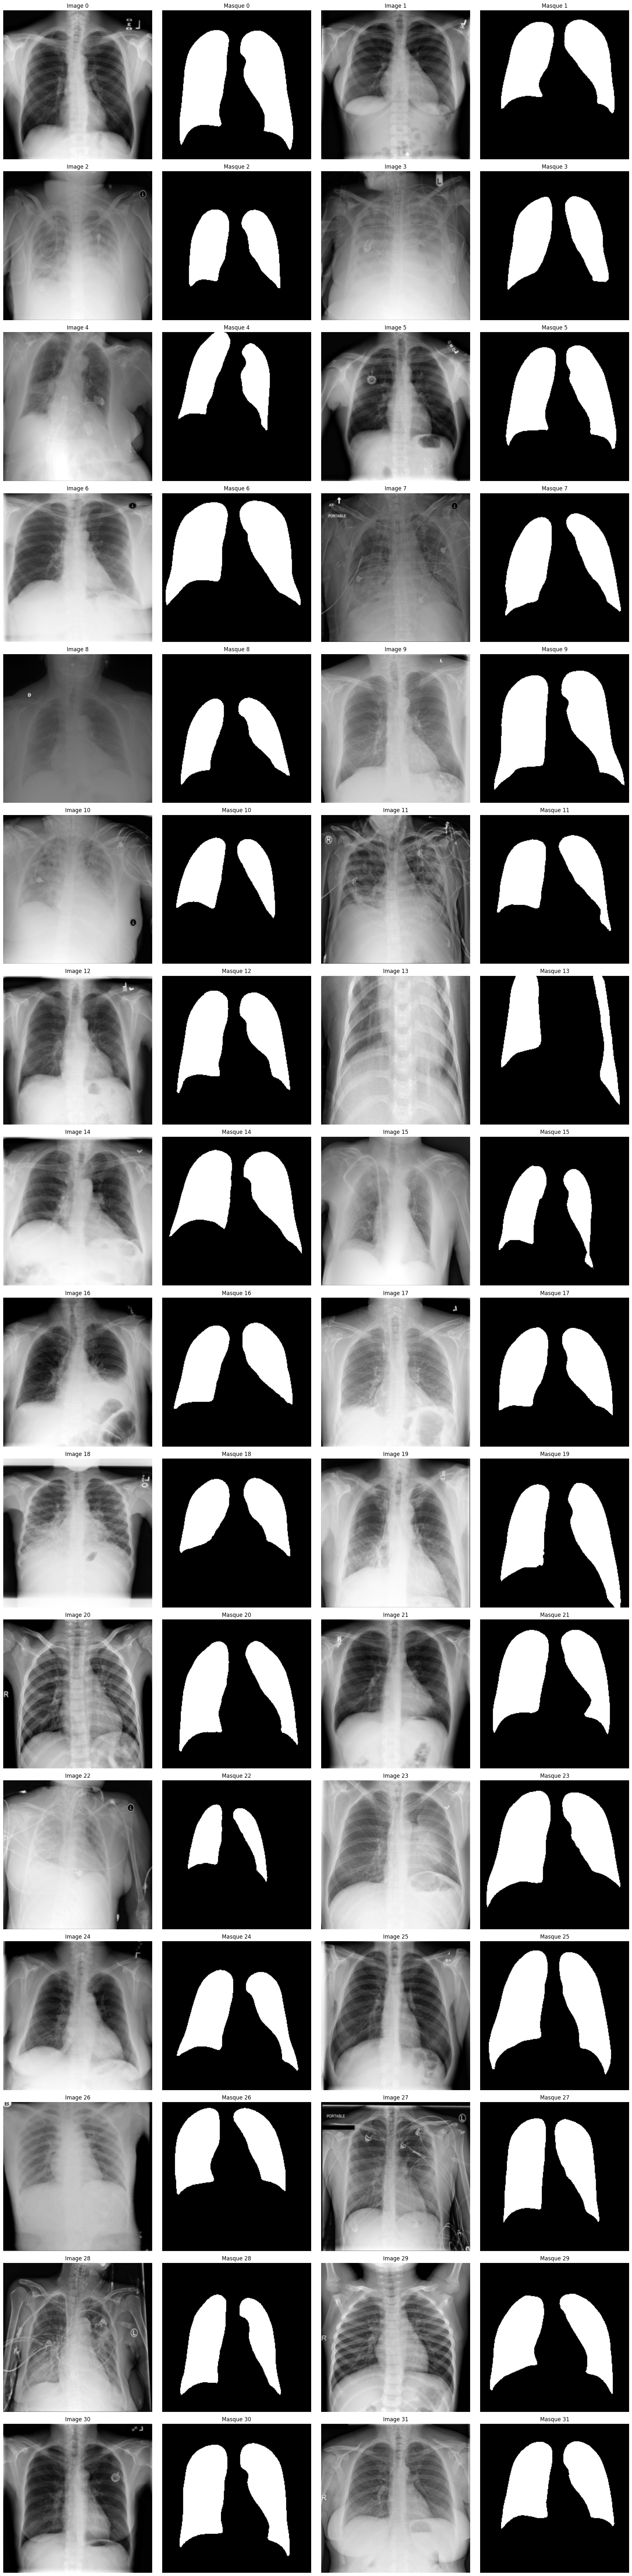

In [10]:
# Extraire un batch
images, masks = next(iter(train_ds))

# Afficher toutes les images du batch
batch_size = images.shape[0]

plt.figure(figsize=(20, batch_size * 2.5))
j = 0
for i in range(1, 2*batch_size, 2):
    plt.subplot(batch_size // 2, 4, i)
    plt.imshow(images[j].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Image {j}')

    plt.subplot(batch_size// 2, 4, i + 1)
    plt.imshow(masks[j].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Masque {j}')
    j += 1

plt.tight_layout()
plt.show()

In [11]:
# Les masques sont bien des images binaires, on peut vérifier les valeurs uniques
np.unique(masks[0].numpy())

array([0., 1.], dtype=float32)

# Modélisation

In [12]:
def down_block(x, filters):
    """
    Downsampling block for the U-Net model.
    """
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def up_block(x, skip, filters):
    """
    Upsampling block for the U-Net model.
    """
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip])
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def build_unet(input_shape):
    """
    Build the U-Net model.
    """
    inputs = Input(shape=input_shape)

    # Downsampling path
    temp1, x = down_block(inputs, 16)
    temp2, x = down_block(x, 32)
    temp3, x = down_block(x, 64)
    temp4, x = down_block(x, 128)

    # Bottleneck
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)

    # Upsampling path
    x = up_block(bottleneck, temp4, 128)
    x = up_block(x, temp3, 64)
    x = up_block(x, temp2, 32)
    x = up_block(x, temp1, 16)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [ ]:
# Définition des callbacks

model_path = r"..\models\unet_filters_c1_16.h5"

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                                  monitor='val_mean_io_u',
                                  verbose=1,
                                  save_best_only=True,
                                  mode="max")

earlystop = EarlyStopping(monitor="val_loss",
                          mode="min",
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor="val_loss",
                             min_lr=0.00001,
                             patience=4,
                             factor=0.5,
                             cooldown=2,
                             verbose=1)

In [14]:
root_logdir = os.path.join(os.curdir, 'reports/my_logs')

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [15]:
tensorboard = TensorBoard(run_logdir)

In [16]:
# Construction du modèle U-Net
input_shape = (256, 256, 1)
unet = build_unet(input_shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 1,968,225 (7.51 MB)

 Trainable params: 1,965,281 (7.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [17]:
# Compilation du modèle
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [18]:
with tf.device('/GPU:0'):
    # Entraînement du modèle
    history = unet.fit(train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        callbacks=[modelcheckpoint, earlystop, reducelr, tensorboard],
                        verbose=1)

Epoch 1/50


/home/antoine/MachineLearning/projects/COVID19/Radiography_project_LungIsolation/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)
I0000 00:00:1747254897.766394  320357 service.cc:152] XLA service 0x7f565c046490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747254897.766441  320357 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-14 22:34:57.940014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747254898.894536  320357 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-14 22:35:07.873282: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Alloca

462/463 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9620 - loss: 0.1318 - mean_io_u: 0.3812

2025-05-14 22:37:39.305533: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9620 - loss: 0.1316 - mean_io_u: 0.3813

2025-05-14 22:38:11.557841: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


463/463 ━━━━━━━━━━━━━━━━━━━━ 214s 382ms/step - accuracy: 0.9621 - loss: 0.1315 - mean_io_u: 0.3813 - val_accuracy: 0.9753 - val_loss: 0.0786 - val_mean_io_u: 0.4002 - learning_rate: 0.0010
Epoch 2/50


/home/antoine/MachineLearning/projects/COVID19/Radiography_project_LungIsolation/.venv/lib/python3.9/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_mean_iou available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


463/463 ━━━━━━━━━━━━━━━━━━━━ 128s 277ms/step - accuracy: 0.9895 - loss: 0.0280 - mean_io_u: 0.4736 - val_accuracy: 0.9839 - val_loss: 0.0442 - val_mean_io_u: 0.6061 - learning_rate: 0.0010
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 128s 277ms/step - accuracy: 0.9911 - loss: 0.0224 - mean_io_u: 0.6132 - val_accuracy: 0.9913 - val_loss: 0.0220 - val_mean_io_u: 0.6767 - learning_rate: 0.0010
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 128s 277ms/step - accuracy: 0.9923 - loss: 0.0188 - mean_io_u: 0.6712 - val_accuracy: 0.9927 - val_loss: 0.0182 - val_mean_io_u: 0.8379 - learning_rate: 0.0010
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 131s 284ms/step - accuracy: 0.9922 - loss: 0.0192 - mean_io_u: 0.6802 - val_accuracy: 0.9799 - val_loss: 0.0669 - val_mean_io_u: 0.5852 - learning_rate: 0.0010
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 132s 286ms/step - accuracy: 0.9933 - loss: 0.0162 - mean_io_u: 0.6707 - val_accuracy: 0.9920 - val_loss: 0.0206 - val_mean_io_u: 0.5931 - learning_rate: 0.0010
Epoch 7/50
